In [1]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
import glob
import networkx as nx
import Bio.KEGG.KGML.KGML_parser as keg

import pickle
import matplotlib.patches as mpatches

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import cmapPy.pandasGEXpress.parse as cp
import cmapPy.pandasGEXpress.write_gctx as cw

python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]
numpy 1.26.4
pandas 2.2.3
matplotlib 3.10.0


# entrez to sym gene mapping

In [2]:
# mapping human gene symbol to entrez
dat=pd.read_table('data/Sym2Entrez.txt',sep='\t')
dat.columns=['sym','entrez']
dat=dat.loc[dat['entrez'].notnull()]
dat=dat.loc[dat['sym'].notnull()]
dat['entrez']=dat['entrez'].astype(int).astype(str)
s2e_dic=dat.set_index('sym')['entrez']
e2s_dic=dat.set_index('entrez')['sym']

,gs,roc_auc,agg_method
27,TTD,0.803069,max
28,drugbank,0.800543,max


<Axes: xlabel='gs', ylabel='roc_auc'>

roc_auc
gs       agg_method          
TTD      Max.        0.794430
         Ave.        0.551001
         Med.        0.509881
drugbank Max.        0.778856
         Ave.        0.581113
         Med.        0.537975

,gs,roc_auc,corr_weight_method
27,TTD,0.803069,exp_abs(cor)
28,drugbank,0.800543,exp_abs(cor)


<Axes: xlabel='gs', ylabel='roc_auc'>

roc_auc
gs       corr_weight_method          
TTD      exp$^{|cor|}$       0.794430
         exp$^{cor}$         0.781880
drugbank exp$^{|cor|}$       0.778856
         exp$^{cor}$         0.771885

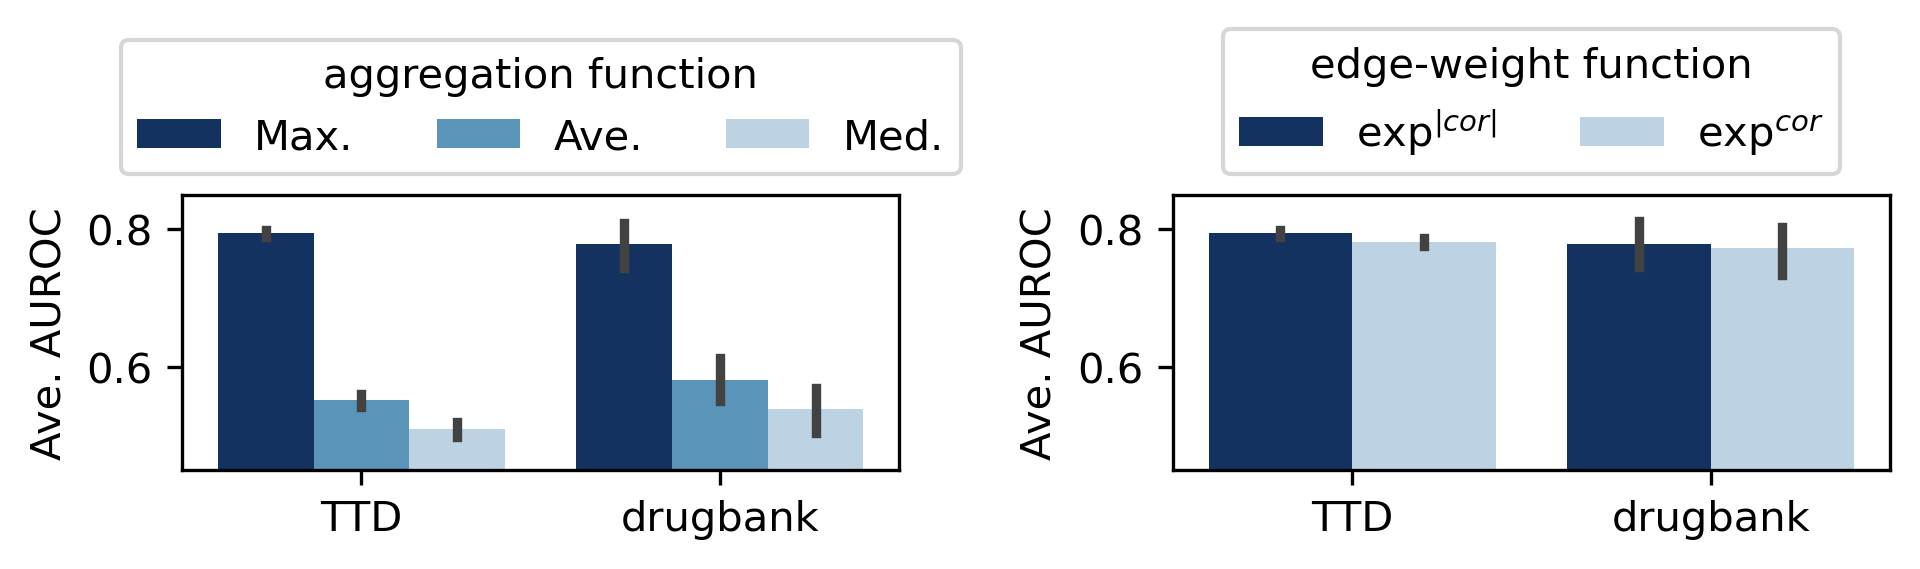

In [56]:
fig=plt.figure(figsize=(6.5,2), dpi=300)
ax1, ax2=fig.subplots(1,2).flatten()

## ax1
with open("./results/two_ppi_agg_p_eval_res.pickle", 'rb') as file:
    auroc_res_ori=pickle.load(file)

tmp_df=auroc_res_ori['score_sys'].str.split('|', expand=True)
tmp_df.columns=['net','agg_method','exp_type','corr_weight_method','agg_p']

auroc_res=pd.concat([auroc_res_ori.drop(columns='score_sys'), tmp_df], axis=1)

## NCES
auroc_res=auroc_res.loc[((auroc_res['net']=='omnipath_all_ppi')&
                         (auroc_res['agg_p']=='0.8')&
                         (auroc_res['exp_type']=='crispr')&
                         (auroc_res['corr_weight_method']=='exp_abs(cor)'))]
auroc_res=auroc_res[['gs','roc_auc','agg_method']]
auroc_res.head(2)

cmap = plt.get_cmap('Blues')
colors = [cmap(v) for v in [1.0, 0.6, 0.3]]
auroc_res['agg_method']=auroc_res['agg_method'].replace({'max': 'Max.', 'ave': 'Ave.', 'med': 'Med.'})
sns.barplot(data=auroc_res, x='gs', y='roc_auc', hue='agg_method', ax=ax1, hue_order=['Max.','Ave.','Med.'], palette=colors)

auroc_res.groupby(['gs','agg_method'])['roc_auc'].mean().to_frame().sort_values(by=['gs', 'roc_auc'], ascending=[True, False])
## ax2
with open("./results/two_ppi_agg_p_eval_res.pickle", 'rb') as file:
    auroc_res_ori=pickle.load(file)

tmp_df=auroc_res_ori['score_sys'].str.split('|', expand=True)
tmp_df.columns=['net','agg_method','exp_type','corr_weight_method','agg_p']

auroc_res=pd.concat([auroc_res_ori.drop(columns='score_sys'), tmp_df], axis=1)

## NCES
auroc_res=auroc_res.loc[((auroc_res['net']=='omnipath_all_ppi')&
                         (auroc_res['agg_p']=='0.8')&
                         (auroc_res['exp_type']=='crispr')&
                         (auroc_res['agg_method']=='max')&
                         (auroc_res['corr_weight_method']!='no_cor'))]
auroc_res=auroc_res[['gs','roc_auc','corr_weight_method']]
auroc_res.head(2)
auroc_res['corr_weight_method']=auroc_res['corr_weight_method'].replace({'exp_abs(cor)': 'exp$^{|cor|}$', 'exp_cor': 'exp$^{cor}$'})

cmap = plt.get_cmap('Blues')
colors = [cmap(v) for v in [1.0, 0.3]]
sns.barplot(data=auroc_res, x='gs', y='roc_auc', hue='corr_weight_method', ax=ax2, palette=colors)

auroc_res.groupby(['gs','corr_weight_method'])['roc_auc'].mean().to_frame().sort_values(by=['gs', 'roc_auc'], ascending=[True, False])

ii=0
for ax in [ax1, ax2]:
    if ii==0:

        _=ax.legend(bbox_to_anchor=(0.5,1), loc='lower center', ncol=3, title='aggregation function')
    if ii==1:
        _=ax.legend(bbox_to_anchor=(0.5,1), loc='lower center', ncol=2, title='edge-weight function')
    _=ax.set_ylabel('Ave. AUROC')
    _=ax.set_ylim(0.45,0.85)
    _=ax.set_xlabel('')
    ii+=1


fig.tight_layout()
fig.savefig('figures/ablation_res.png', bbox_inches='tight', dpi=300)